# Final Project Submission

Please fill out:
* Student name: Akshay Ghalasi
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Setup and import data


In [11]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
%run "Auxillary.ipynb"

In [2]:
#from auxillary import withnfeatures
#from auxillary import cattonum

In [13]:
df = pd.read_csv('kc_house_data.csv')
#understanding size of data
print(df.shape)
df.head(5)

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Data prepreprocessing

0
0
0
0
0.10999397674095353
0.006764583236806746
0


0

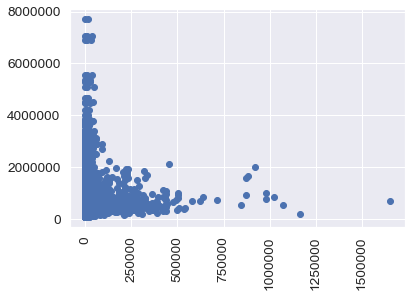

In [14]:
#id seems like a random assignment. we will drop it
df.drop('id',axis=1,inplace=True)

# date needs to be parsed in year, month and day. We dont expect day to carry lot of information but we will keep it for now
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df.drop('date',axis=1,inplace=True)


#Not all non numerical enries are stored as nans. So I am converting all non numerical entries to nan
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

df = df[df.applymap(isnumber)]

#price is our target variable so we will leave it alone for now
#Bedroom has no NaNs
print(df['bedrooms'].isna().sum())
plt.plot(df['bedrooms'],df['price'],'bo')
#There is a bedroom with 33 rooms so with incredibly low price so we are going to remove that as an anomaly
df = df[df.bedrooms < 12]

#bathrooms has no NaNs and no obvious outliers so we will leave it alone for noe
df['bathrooms'].isna().sum()

#sqftliving, there is a clear linear relationship with a large spread. However there are clear outliers we will remove
print(df['sqft_living'].isna().sum())
plt.plot(df['sqft_living'],df['price'],'bo')
plt.xticks(rotation='vertical')
df = df[df.sqft_living < 11800]

#sqftlot, there no clear linear relationship. However there are clear outliers we will remove
print(df['sqft_lot'].isna().sum())
plt.plot(df['sqft_lot'],df['price'],'bo')
plt.xticks(rotation='vertical')
df = df[df.sqft_lot < 800000]

#Floors has no NaNs and no clear outlier. Will keep all for now
print(df['floors'].isna().sum())
df['floors'].unique()

#Waterfront has 10% nan's Only 0.1% of homes have a waterfront. We will replace nan's with zeros
print(df['waterfront'].isna().sum()/df.shape[0])
print((df['waterfront']==1).sum()/df.shape[0])
df['waterfront'] = df['waterfront'].fillna(0)

# view is a little puzzling as to what it means but we will replace the nans  with the median i.e. 0
df['view'] = df['view'].fillna(df['view'].median())

# condition is an important indicator and there are no NaN's so we will leave it for the moment
df['condition'].isna().sum()
#plt.plot(df['condition'],df['price'],'bo')

# grade is an important indicator and has a clear linear relationship and there are no NaN's so we will leave it for the moment
df['grade'].isna().sum()
#plt.plot(df['grade'],df['price'],'bo')

#sqft above has a clear linear relationship and no nans so we will keep it
df['sqft_above'].isna().sum()
df['sqft_above'].isna().sum()
#plt.plot(df['sqft_above'],df['price'],'bo')

#sqft basement has nans which we replace with the median i.e. 0. Its also stored as strings for some reason, convert it to float
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['sqft_basement'] = df['sqft_basement'].fillna(df['sqft_basement'].median())
#after normalizing by sqft_above there is no linear relationship. So we will convert it to bool
#plt.plot(df['sqft_basement']/df['sqft_above'],df['price'],'bo')

#Coverting it to categorical
df['has_bsmt'] = df['sqft_basement'].apply(lambda x: 1 if x>0.0 else 0)
df.drop('sqft_basement',axis=1,inplace=True)

#yr built has no nans so we will keep it for now
print(df['yr_built'].isna().sum())

#if yr_renovated is 0 or nan replace it with year built # first i will convert all 0's to nan's and then replace them
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: None if x==0 else x)
df['yr_renovated'].fillna(df['yr_built'],inplace=True)

#no nans in zipcode. This is the true categorical variable and an interesting one. We will deal with it later
df['zipcode'].isna().sum()
#
df['sqft_living15'].isna().sum()
df['sqft_lot15'].isna().sum()

# Setting a benchmark

### It is important to set a benchmark of the predictions we make to know if and why we are improving. I will use two benchmark models to predict the price of the house and see how it improves

## Benchmark 1. Linear model based on existing features without any preprocessing

221120.6629735167


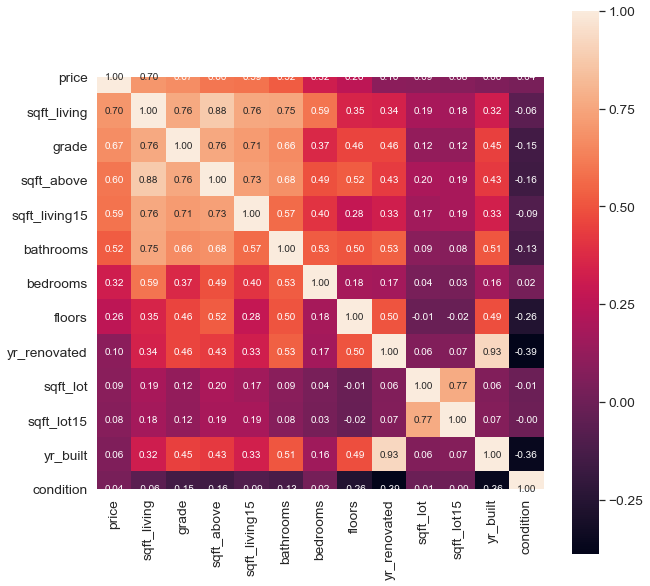

In [15]:
## Here I will create a list of features that have not been preprocessed and make a linear fit.
## First I chose features such that I expect them to have a linear relationship with the target
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15']
ben_1_df = df[lin_feats]

## Lets get a corrmat to figure out what the most important variables are
corrmat = ben_1_df.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=1., square=True);
k = ben_1_df.shape[1] #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(ben_1_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
#plt.show()

## Here I will create a list of features that have not been preprocessed and make a linear fit.
## First I chose features such that I expect them to have a linear relationship with the target
y = ben_1_df['price']
X = ben_1_df.drop('price',axis=1)

## Making a linear fit. First do a train-test split, then fit on train using sklearn linear model and testing predictions on test

# Making a train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


# Doing Ridge regression
ridge = RidgeCV(alphas=np.logspace(0,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_

#Calculate rmse
testpred[testpred < 0] = np.mean(y_train)
benchmark_1 = np.sqrt(((testpred-y_test)**2).sum()/len(y_test))
print(benchmark_1)


## Benchmark 2. Groupby zipcode, Find average house cost/sqft in the zipcode and multipy by sqft living

In [16]:
# I dont do a train test split here since this is a simple prediction
df['pricepersqft'] = df['price']/df['sqft_living']

df['pricepersqft'] = df.groupby(['zipcode'])['pricepersqft'].transform('mean') 

testpred = df['pricepersqft']*df['sqft_living']
benchmark_2 = np.sqrt(((testpred-df['price'])**2).sum()/testpred.shape[0])
print(benchmark_2)

173036.8652126837


### Benchmark 2 is the one to beat. Lets see if we can make sequential improvements to our predictions to improve the result

## Log transform target and skewed features to get better distrubutions

0.22094253155355675
179084.7679892318


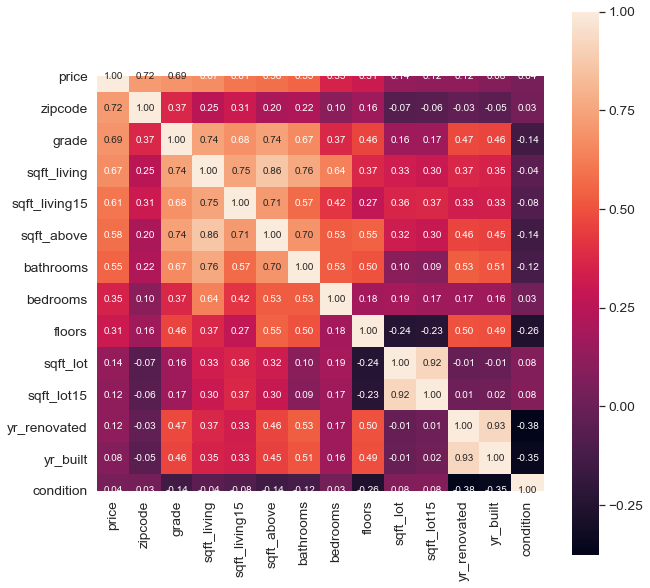

In [32]:
#skewed_feats = df[lin_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats = skewed_feats.index
#print(skewed_feats)
#df_log = df[lin_feats].copy()
#df_log[skewed_feats] = np.log1p(df_log[skewed_feats])
#remember log1p is log(1+x)
df_log = fix_skewed(df,lin_feats)
## Lets see the cormat again. It chages a little bit
## Lets get a corrmat to figure out what the most important variables are
corrmat = df_log.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=1., square=True);
k = df_log.shape[1] #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_log[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
#plt.show()

# The improvement after taking a log transformation is only a modest one
y = df_log['price']
X = df_log.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(0,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
    
#Calculate rmse
testpred[testpred < 0] = np.mean(y_train)
logerr = np.sqrt(((testpred-y_test)**2).sum()/len(y_test))
print(logerr)
act_err = np.sqrt((((np.exp(testpred)-1)-(np.exp(y_test))-1)**2).sum()/len(y_test))
print(act_err)

### Lets see if the behavior is as we expect as we keep adding more features

[0.36410254018403176, 0.2709058238507153, 0.2394786228062113, 0.2394576242300739, 0.23907231774329962, 0.2390204473104826, 0.23865917355611682, 0.23860049173143213, 0.23852114985097844, 0.2379030191129809, 0.22724668467584325, 0.22165354815653057, 0.2209425316331287]


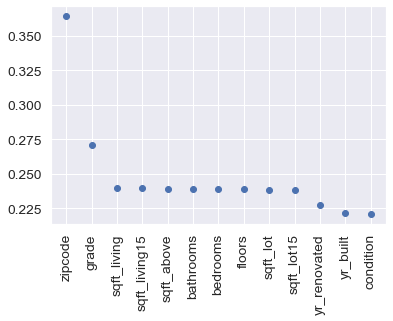

In [33]:
el = []
for x in range(1,df_log.shape[1]):
    e,l,ae = withnfeatures(df_log,x)
    el.append(e)
labels = withnfeatures(df_log,x)[1]
print(el)
plt.plot(range(1,df_log.shape[1]),el,'bo');
plt.xticks(range(1,df_log.shape[1]), labels, rotation='vertical');


#### It is decreasing monotonically

### We will try two different methods with zipcode. First we will convert zipcode categorical data to numerical.

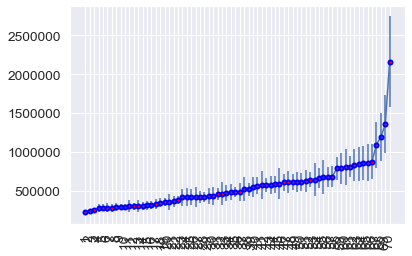

In [34]:
cattonum(df,'zipcode','price')

### Now to do linear regression using category as a continuous variabe

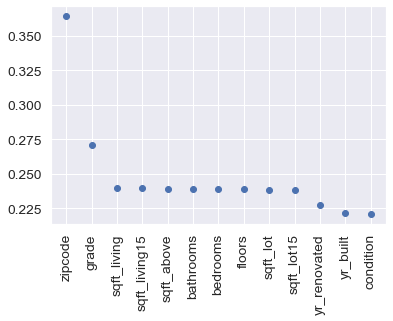

In [35]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode']

df_log = fix_skewed(df,lin_feats)


#### Now zipcode is the most correlated Lets run linear regression again
el = []
for x in range(1,df_log.shape[1]):
    e,l,ae = withnfeatures(df_log,x)
    el.append(e)
labels = withnfeatures(df_log,x)[1]
plt.plot(range(1,df_log.shape[1]),el,'bo');
plt.xticks(range(1,df_log.shape[1]), labels, rotation='vertical');

#### We get a huge improvement

## Does getdummies work as well or better for zipcode?

[0.37718757000556263, 0.35728772448612534, 0.3555637018495611, 0.3529232482513147, 0.35292616694941614, 0.3525042386768673, 0.35251549856704584, 0.3450353420730478, 0.34167987114522025, 0.3329566809714581, 0.3277100230115147, 0.3266778174718478, 0.32424350258425233, 0.31890881137606364, 0.3134175801320995, 0.3128097369882951, 0.30996271610847526, 0.30897021671170555, 0.2898330302262589, 0.28957854009124656, 0.284717430553376, 0.2821662341962754, 0.27800445553728403, 0.2759127341608032, 0.2742863827217935, 0.2725139054854855, 0.27190500677182117, 0.2694148801387967, 0.265935225924059, 0.262215565139888, 0.26009230434856634, 0.2546618941776346, 0.254614795496066, 0.25023574176753055, 0.24585013595940539, 0.24539324208875668, 0.24412744775209436, 0.24061930877579432, 0.23929847368866672, 0.2388448806030665, 0.2333962424543972, 0.2327248764945704, 0.2304564577395978, 0.22765978589954836, 0.2268408460443304, 0.22631350512148277, 0.22598585424150033, 0.2252143114213058, 0.2252042663645329, 0

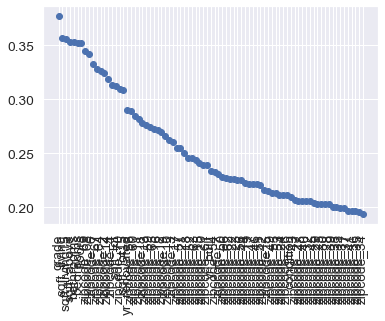

In [39]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode']

df_dummies = fix_skewed(df,lin_feats)
df_dummies = pd.get_dummies(df_dummies, columns=['zipcode'],drop_first=True)

el = []
for x in range(1,df_dummies.shape[1]):
    e,l,ae = withnfeatures(df_dummies,x)
    el.append(e)
print(el)
labels = withnfeatures(df_dummies,x)[1]
plt.plot(range(1,df_dummies.shape[1]),el,'bo');
plt.xticks(range(1,df_dummies.shape[1]), labels, rotation='vertical');

#### One hot encoding does slightly better

## Can we do a seperate linear fit for every different zipcode and does it work better?